<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e8?scriptVersionId=120373732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [13]:
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso,Ridge
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e8'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e8/sample_submission.csv
/kaggle/input/playground-series-s3e8/train.csv
/kaggle/input/playground-series-s3e8/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e8

In [14]:
train = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')

In [15]:
for i in test.columns:
    print(test[i].value_counts())

193573    1
279601    1
279614    1
279613    1
279612    1
         ..
236585    1
236584    1
236583    1
236582    1
322622    1
Name: id, Length: 129050, dtype: int64
0.30    7259
1.01    6726
0.31    6083
0.70    5373
0.32    5201
        ... 
1.88       1
2.65       1
2.49       1
0.22       1
1.96       1
Name: carat, Length: 252, dtype: int64
Ideal        61223
Premium      33498
Very Good    25468
Good          7554
Fair          1307
Name: cut, dtype: int64
G    29561
E    24086
F    22767
H    20576
D    16167
I    11685
J     4208
Name: color, dtype: int64
SI1     35336
VS2     32201
VS1     20519
SI2     20167
VVS2    10317
VVS1     7327
IF       2791
I1        392
Name: clarity, dtype: int64
61.9    7017
62.0    6715
61.8    6139
62.1    5764
61.6    5715
        ... 
53.2       1
68.1       1
56.6       1
69.2       1
67.9       1
Name: depth, Length: 143, dtype: int64
56.0    28112
57.0    25371
58.0    21414
55.0    16237
59.0    15854
        ...  
62.6        1
62.8 

### Summary stats

In [16]:
train.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


### Drop id from train and test set

In [17]:
train.drop(columns = ['id'], inplace = True)
test.set_index(['id'], inplace = True)

### Plotting the categorical variables

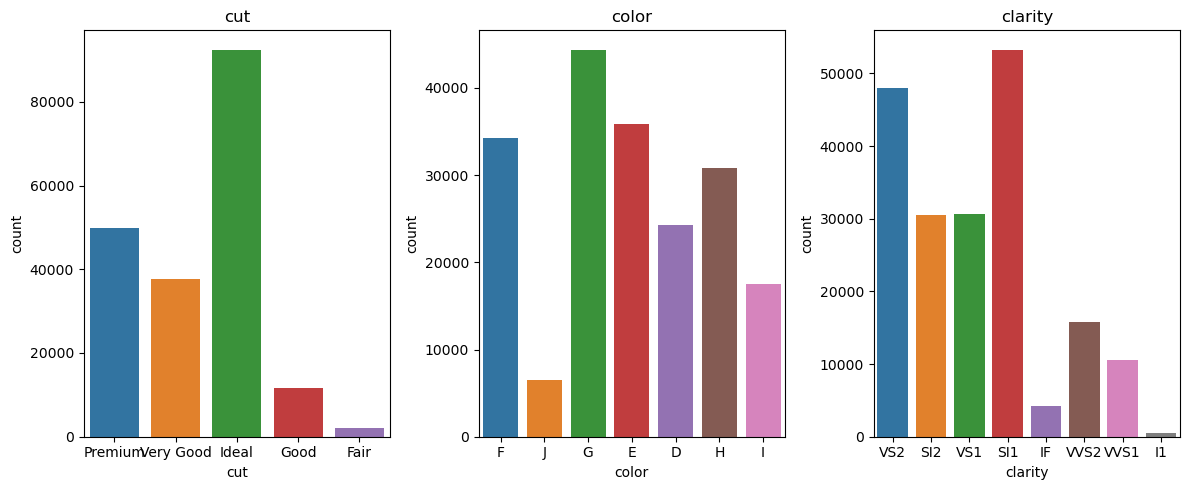

In [18]:
fig, axes = plt.subplots(nrows =1, ncols = 3 , figsize=(12,5))
for i, ax in enumerate(axes.flat):
    if i <len(['cut', 'color', 'clarity']):
        sns.countplot(x= train[(['cut', 'color','clarity'])[i]], ax = ax)
        ax.set_title(['cut', 'color', 'clarity'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Plotting the continuous variables

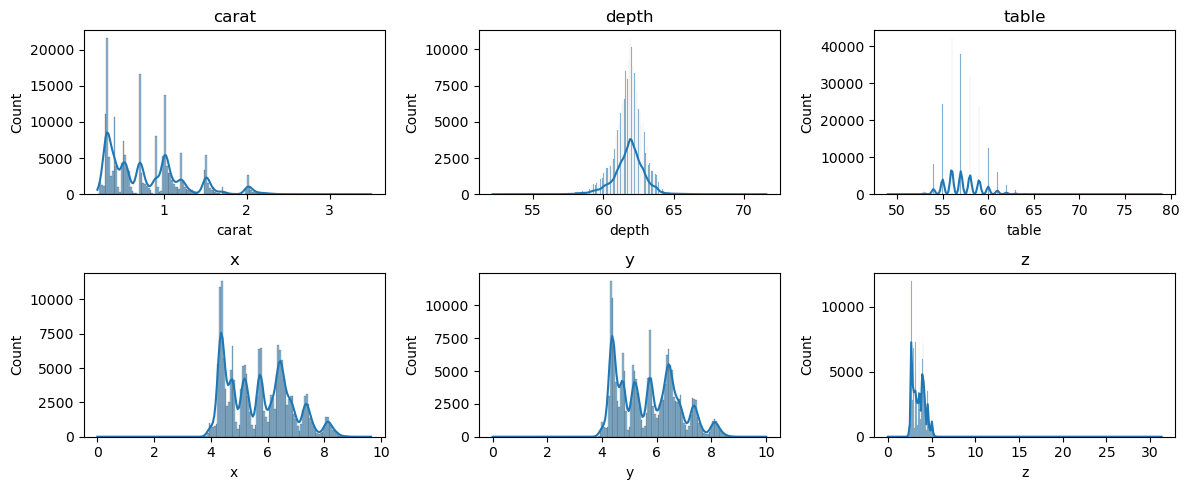

In [19]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (12,5))
for i, ax in enumerate(axes.flat):
    if i < len(['carat', 'depth', 'table', 'x', 'y', 'z']):
        sns.histplot(x= train[(['carat', 'depth', 'table', 'x', 'y', 'z'][i])], ax = ax, kde = True)
        ax.set_title(['carat', 'depth', 'table', 'x', 'y', 'z'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Plotting the target variable

<AxesSubplot:xlabel='price', ylabel='Count'>

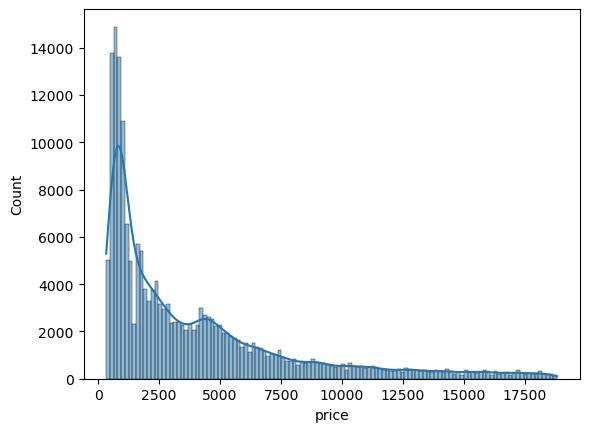

In [20]:
sns.histplot(x= train.price, kde = True)

## Target encoding preferred over frequency encoding as the results were marginally better
### Target encoding the categorical variables

In [4]:
te = TargetEncoder(cols = ['cut', 'color', 'clarity'])
te.fit(train[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']], train['price'])
train[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']] = te.transform(train[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']])
test = te.transform(test)

### Frequency encoding for the variables- train set

In [ ]:
for i in ['cut', 'color', 'clarity']:
    train[i]= train[i].map(train[i].value_counts(normalize = True))

### Frequency encoding for the variables- test set

In [ ]:
for i in ['cut', 'color', 'clarity']:
    test[i]= test[i].map(test[i].value_counts(normalize = True))

### Co-relation map 

In [21]:
corr = train.corr()
corr.style.background_gradient(cmap= 'coolwarm')

,carat,depth,table,x,y,z,price
carat,1.000000,0.027852,0.225737,0.980563,0.980161,0.974274,0.943396
depth,0.027852,1.000000,-0.230631,-0.010762,-0.011653,0.081821,0.001880
table,0.225737,-0.230631,1.000000,0.237578,0.233299,0.212208,0.174915
x,0.980563,-0.010762,0.237578,1.000000,0.999109,0.989724,0.901004
y,0.980161,-0.011653,0.233299,0.999109,1.000000,0.989527,0.901033
z,0.974274,0.081821,0.212208,0.989724,0.989527,1.000000,0.893037
price,0.943396,0.001880,0.174915,0.901004,0.901033,0.893037,1.000000


### Separating features and target variable

In [7]:
y = train.price
train.drop(columns = ['price'], inplace = True)

### Define a function for model evaluation

In [8]:
def model_eval(train,y,param,model):
    scores = []
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    random = RandomizedSearchCV(model, param,cv= inner_cv, n_jobs = -1, scoring = 'neg_mean_squared_error', random_state = 0 )
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(train,y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy,testy = y[train_index],y[test_index]
                random.fit(trainx,trainy)
                predy = random.best_estimator_.predict(testx)
                scores.append(np.sqrt(mean_squared_error(testy, predy, squared = False)))
            pbar.update()
    print('Average RMSE', np.mean(scores))
    print(random.best_params_)

### Ridge
### Randomizedsearch with nested cv
Average RMSE 34.08143674500578
{'max_iter': 9577200, 'alpha': 1.0}

In [ ]:
model = Ridge()
param = {'alpha': np.linspace(0,1,10), 'max_iter': np.array(range(100000, 10000000, 100))}
model_eval(train,y,param, model)

In [ ]:
model = Ridge(max_iter = 9577200, alpha = 1)
model.fit(train,y)

### Decision Tree
### Randomizedsearch with nested cv
Average RMSE 51.43523695338668
{'min_samples_split': 31, 'max_depth': 76, 'criterion': 'poisson'}


In [ ]:
model = DecisionTreeRegressor()
param = {'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'], 'min_samples_split': np.array(range(1,300,10)), 'max_depth': np.array(range(1,100,5))}
model_eval(train,y,param,model)

In [ ]:
model = DecisionTreeRegressor(min_samples_split = 31, max_depth = 76, criterion = 'poisson', random_state = 0)
model.fit(train,y)

### Random Forest
### Randomizedsearch with nested cv
Average RMSE 24.438380678769548
{'min_samples_split': 21, 'max_depth': 90, 'criterion': 'friedman_mse'}

In [ ]:
model = RandomForestRegressor(n_estimators = 20)
param = {'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'], 'min_samples_split': np.array(range(1,100,10)), 'max_depth': np.array(range(10,100,10))}
model_eval(train,y,param,model)

In [ ]:
model = RandomForestRegressor(min_samples_split = 21, max_depth = 90, criterion = 'friedman_mse')
model.fit(train,y)

### Extra Trees
### Randomizedsearch with nested cv
Average RMSE 24.501671310161658
{'min_samples_split': 21, 'max_depth': 90, 'criterion': 'friedman_mse'}

In [ ]:
model = ExtraTreesRegressor(n_estimators = 20)
param = {'criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'], 'min_samples_split': np.array(range(1,100,10)), 'max_depth': np.array(range(10,100,10))}
model_eval(train,y,param,model)

In [ ]:
model = ExtraTreesRegressor(min_samples_split = 21, max_depth = 90, criterion = 'friedman_mse')
model.fit(train,y)

### Ada Boost
### Randomizedsearch with nested cv
Average RMSE 37.998452010404066
{'n_estimators': 420, 'learning_rate': 0.30303030303030304}

In [ ]:
model = AdaBoostRegressor()
n_estimators = np.array(range(100, 1000,10))
learning_rate = np.linspace(0,1, 100)
param = {'n_estimators': n_estimators, 'learning_rate': learning_rate}
model_eval(train,y,param,model)

In [ ]:
model = AdaBoostRegressor(n_estimators = 420, learning_rate = 0.30)
model.fit(train,y)

### Bagging Regressor
### Randomizedsearch with nested cv
Average RMSE 29.7484554762927
{'n_estimators': 70, 'max_features': 4}

In [ ]:
model = BaggingRegressor()
n_estimators = np.array(range(50,200,10))
max_features = np.array(range(1, 10))
param = {'n_estimators': n_estimators, 'max_features': max_features}
model_eval(train,y,param,model)

In [ ]:
model = BaggingRegressor(n_estimators = 70, max_features = 4)
model.fit(train,y)

### XG Boost
### Nested cv
Average RMSE 24.334631004509873

In [ ]:
model = XGBRegressor(objective='reg:squarederror',
                     eval_metric='rmse')
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(np.sqrt(mean_squared_error(testy, predy, squared = False)))
print('Average RMSE', np.mean(scores))

### LGBM Regressor
### Nested CV
Average RMSE 24.113361764820468


In [11]:
model = LGBMRegressor(verbosity = -100)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(np.sqrt(mean_squared_error(testy, predy, squared = False)))
print('Average RMSE', np.mean(scores))

Average RMSE 24.05087218663121


# The best model
### Cat Boost
### Nested CV
Average RMSE 24.082238847961797

In [9]:
model = CatBoostRegressor(verbose = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                predy = model.predict(testx)
                scores.append(np.sqrt(mean_squared_error(testy, predy, squared = False)))
print('Average RMSE', np.mean(scores))

Average RMSE 24.024119211002994


In [12]:
predictions = pd.DataFrame(model.predict(test), index = test.index, columns = ['price'])
predictions.to_csv('submission.csv', index = True)